Very bad model, however, I'm now able to use regression data in my GNN

## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [179]:
from torch_geometric.datasets import PPI
from torch_geometric.data import Data

dataset = PPI(root="/tmp/PPI")
data = dataset[0]

all_x = []
all_edge_index = []
all_edge_attr = []
all_y = []
all_train_mask = []
all_val_mask = []
all_test_mask = []

node_offset = 0

for data in dataset:
    num_samples = data.num_nodes
    train_mask = torch.zeros(num_samples, dtype=torch.bool)
    val_mask = torch.zeros(num_samples, dtype=torch.bool)
    test_mask = torch.zeros(num_samples, dtype=torch.bool)

    train_mask[:int(0.8 * num_samples)] = 1
    val_mask[int(0.8 * num_samples):int(0.9 * num_samples)] = 1
    test_mask[int(0.9 * num_samples):] = 1
    
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    
    all_x.append(data.x)
    all_y.append(data.y)
    all_train_mask.append(data.train_mask)
    all_val_mask.append(data.val_mask)
    all_test_mask.append(data.test_mask)

    edge_index = data.edge_index + node_offset
    all_edge_index.append(edge_index)

    if data.edge_attr is not None:
        all_edge_attr.append(data.edge_attr)

    node_offset += data.x.size(0)

x = torch.cat(all_x, dim=0)
y = torch.cat(all_y, dim=0)
train_mask = torch.cat(all_train_mask, dim=0)
val_mask = torch.cat(all_val_mask, dim=0)
test_mask = torch.cat(all_test_mask, dim=0)
edge_index = torch.cat(all_edge_index, dim=1)

edge_attr = torch.cat(all_edge_attr, dim=0) if all_edge_attr else None

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask, edge_attr=edge_attr)
data

Data(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121], train_mask=[44906], val_mask=[44906], test_mask=[44906])

## Statistical Modeling ##

In [181]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [183]:
pd_data.shape

(44906, 50)

In [185]:
pd_data.head(20).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,20.000000,2.000000e+01,20.00000,20.000000,20.000000,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,...,20.000000,2.000000e+01,2.000000e+01,2.000000e+01,20.000000,20.000000,2.000000e+01,20.000000,20.000000,2.000000e+01
mean,-0.085514,-8.837447e-02,-0.11278,0.127538,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936042e-02,...,0.268623,-1.539001e-01,-1.593475e-01,-1.545810e-01,0.201741,0.207266,-1.567571e-01,0.224502,-0.149366,-1.481149e-01
std,0.000000,7.644134e-09,0.00000,1.339168,0.000000,2.293240e-08,7.644134e-09,1.528827e-08,1.528827e-08,2.293240e-08,...,1.774200,1.528827e-08,1.528827e-08,1.528827e-08,1.557900,1.575128,1.528827e-08,1.629642,0.000000,1.528827e-08
min,-0.085514,-8.837446e-02,-0.11278,-0.171909,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936041e-02,...,-0.128101,-1.539001e-01,-1.593474e-01,-1.545810e-01,-0.146616,-0.144943,-1.567570e-01,-0.139898,-0.149366,-1.481148e-01
25%,-0.085514,-8.837446e-02,-0.11278,-0.171909,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936041e-02,...,-0.128101,-1.539001e-01,-1.593474e-01,-1.545810e-01,-0.146616,-0.144943,-1.567570e-01,-0.139898,-0.149366,-1.481148e-01
50%,-0.085514,-8.837446e-02,-0.11278,-0.171909,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936041e-02,...,-0.128101,-1.539001e-01,-1.593474e-01,-1.545810e-01,-0.146616,-0.144943,-1.567570e-01,-0.139898,-0.149366,-1.481148e-01
75%,-0.085514,-8.837446e-02,-0.11278,-0.171909,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936041e-02,...,-0.128101,-1.539001e-01,-1.593474e-01,-1.545810e-01,-0.146616,-0.144943,-1.567570e-01,-0.139898,-0.149366,-1.481148e-01
max,-0.085514,-8.837446e-02,-0.11278,5.817032,-0.076607,-1.002707e-01,-7.512251e-02,-1.148876e-01,-1.211911e-01,-9.936041e-02,...,7.806364,-1.539001e-01,-1.593474e-01,-1.545810e-01,6.820526,6.899244,-1.567570e-01,7.148086,-0.149366,-1.481148e-01


In [187]:
def data_to_nx_subgraph(data, node_range):
    G = nx.Graph()
    
    start, end = node_range
    G.add_nodes_from(range(start, end))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    filtered_edges = [
        (u, v) for u, v in edges if u >= start and u < end and v >= start and v < end
    ]

    G.add_edges_from(filtered_edges)
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

node_range = (0, 500)
G = data_to_nx_subgraph(data, node_range)

In [189]:
nx.cluster.average_clustering(G)

0.18432150304188016

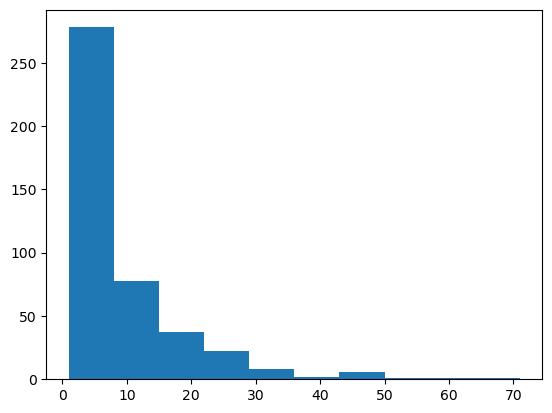

In [191]:
plt.hist([v for k, v in nx.degree(G)]);

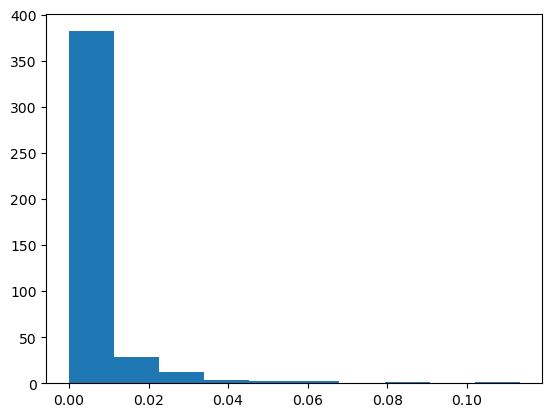

In [193]:
plt.hist(nx.centrality.betweenness_centrality(G).values());

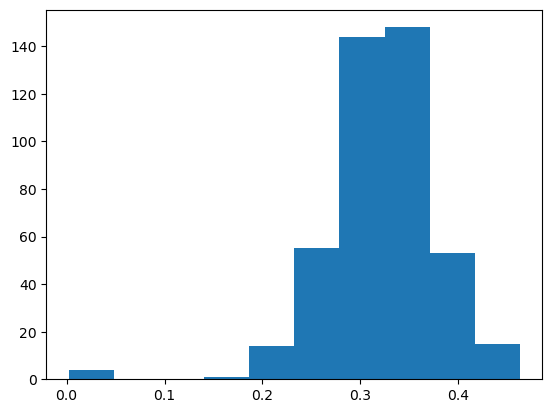

In [195]:
plt.hist(nx.centrality.closeness_centrality(G).values());

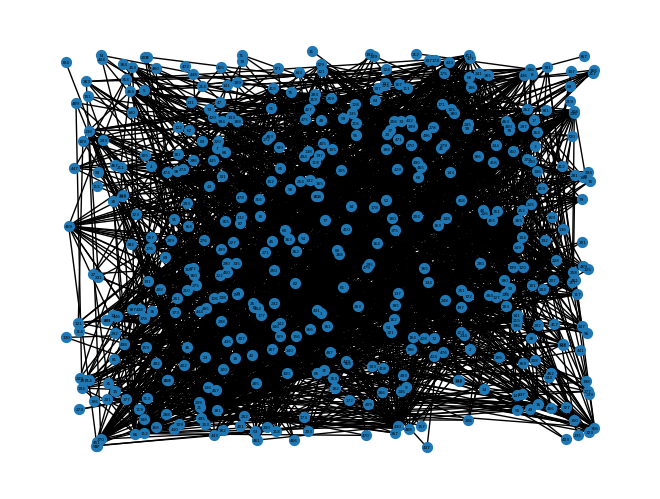

In [197]:
nx.draw_random(G, with_labels=True, node_size=50, font_size=3)
plt.show()

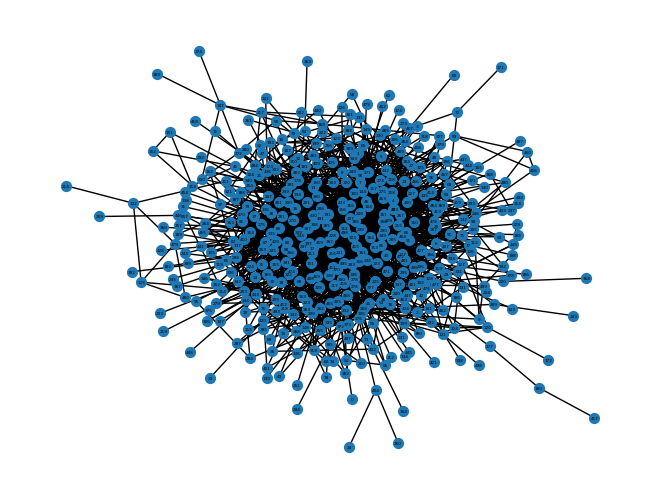

In [199]:
nx.draw_kamada_kawai(G, with_labels=True, node_size=50, font_size=3)

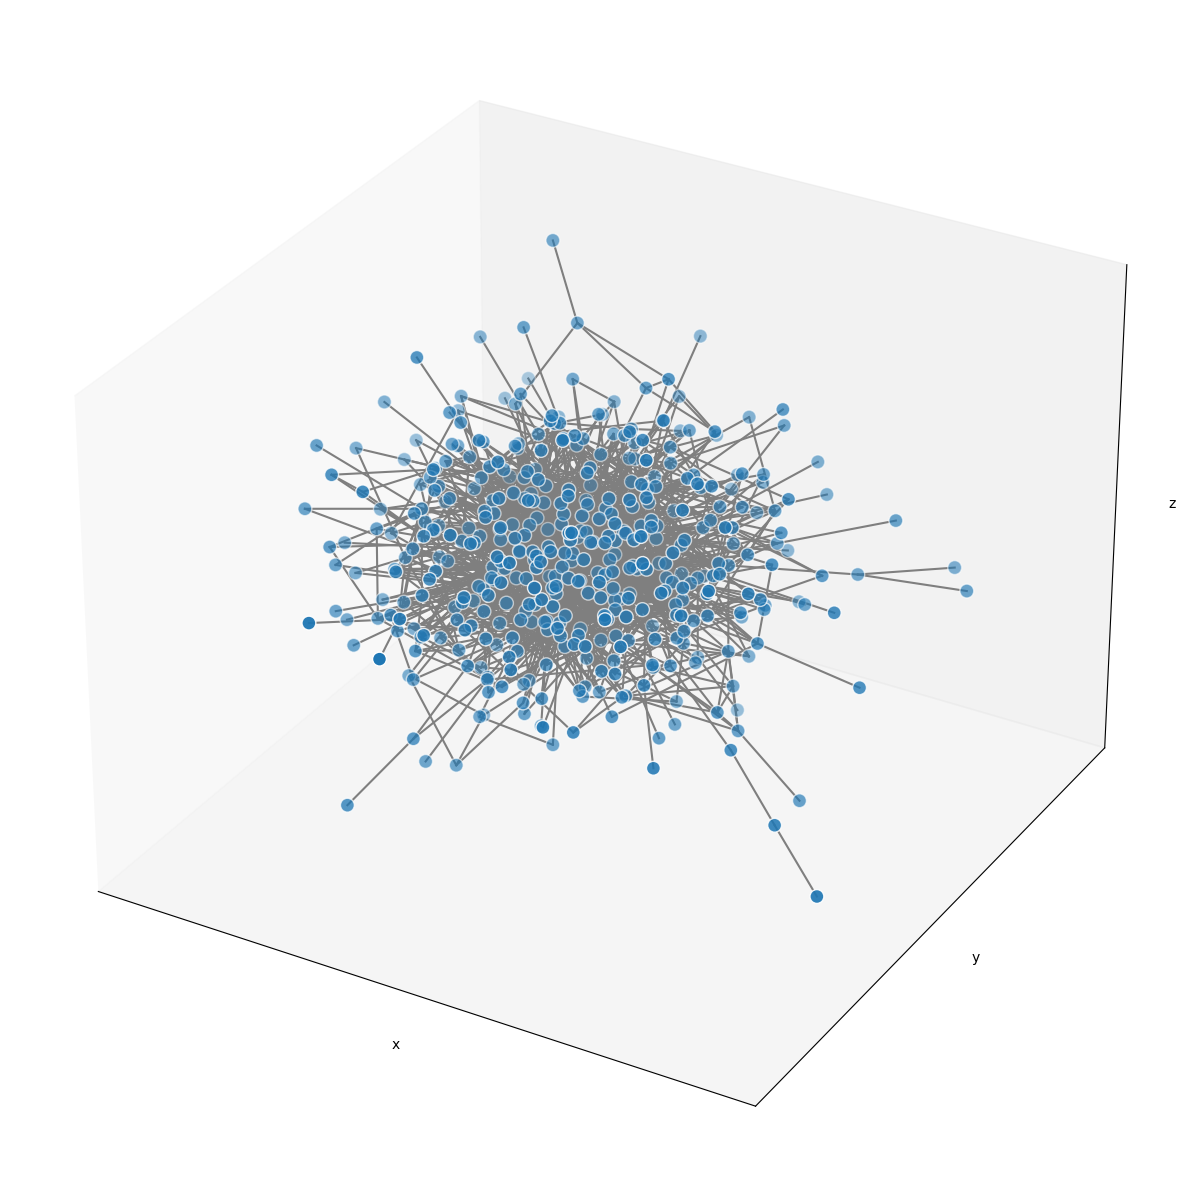

In [200]:
pos = nx.kamada_kawai_layout(G, dim=3)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [202]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        return x

In [205]:
LR = 1e-04
HIDDEN = 250
EPOCHS = 200

In [207]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [209]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           250
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       12,500
├─GCNConv: 1-2                           250
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       62,500
├─GCNConv: 1-3                           250
│    └─SumAggregation: 2-5               --
│    └─Linear: 2-6                       62,500
├─GCNConv: 1-4                           121
│    └─SumAggregation: 2-7               --
│    └─Linear: 2-8                       30,250
Total params: 168,621
Trainable params: 168,621
Non-trainable params: 0

In [211]:
def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)

    if isinstance(criterion, nn.MSELoss):
        target = data.y[data.train_mask].float()
    else:
        target = data.y[data.train_mask]

    loss = criterion(out[data.train_mask], target)
    loss.backward()
    optimizer.step()

    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        true = data.y.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == true[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [215]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f"Epoch: {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {100*test_acc:.2f}%")

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 1, Loss: 178.6522, Test Accuracy: 0.00%
Epoch: 11, Loss: 178.0472, Test Accuracy: 0.00%
Epoch: 21, Loss: 177.3797, Test Accuracy: 0.00%
Epoch: 31, Loss: 176.7143, Test Accuracy: 0.00%
Epoch: 41, Loss: 176.2259, Test Accuracy: 0.38%
Epoch: 51, Loss: 175.9828, Test Accuracy: 1.16%
Epoch: 61, Loss: 175.8633, Test Accuracy: 1.16%
Epoch: 71, Loss: 175.7967, Test Accuracy: 0.11%
Epoch: 81, Loss: 175.7598, Test Accuracy: 0.40%
Epoch: 91, Loss: 175.7355, Test Accuracy: 0.47%
Epoch: 101, Loss: 175.7176, Test Accuracy: 0.44%
Epoch: 111, Loss: 175.7018, Test Accuracy: 0.53%
Epoch: 121, Loss: 175.6863, Test Accuracy: 0.53%
Epoch: 131, Loss: 175.6702, Test Accuracy: 0.49%
Epoch: 141, Loss: 175.6530, Test Accuracy: 0.51%
Epoch: 151, Loss: 175.6344, Test Accuracy: 0.49%
Epoch: 161, Loss: 175.6139, Test Accuracy: 0.49%
Epoch: 171, Loss: 175.5912, Test Accuracy: 0.49%
Epoch: 181, Loss: 175.5658, Test Accuracy: 0.49%
Epoch: 191, Loss: 175.5371, Test Accuracy: 0.51%

Training Time is:  416.808  Se

## Post-Training Analysis ##

In [219]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

In [221]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

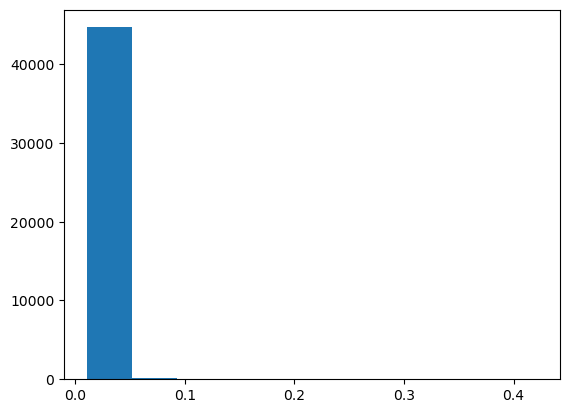

In [223]:
plt.hist(confidence.detach().numpy())
plt.show()

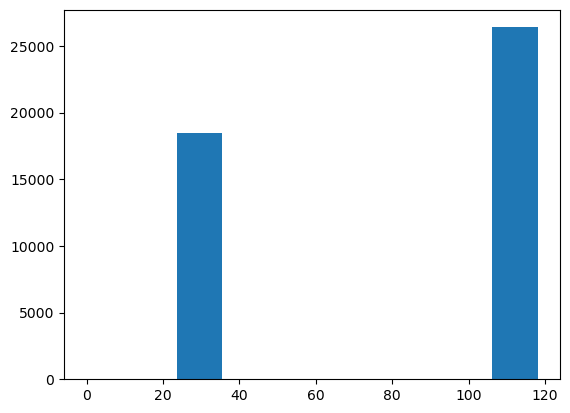

In [225]:
plt.hist(pred_class)
plt.show()

In [227]:
torch.save(model.state_dict(), "model.pth")

In [229]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("model.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(50, 250)
  (conv2): GCNConv(250, 250)
  (conv3): GCNConv(250, 250)
  (conv4): GCNConv(250, 121)
)